# Computational topology - Sensors

You are given a number of points on the sphere of radius 1. You should view them as sensors on the surface of the Earth.  The sensors are used to gather data and form a sensor network with parameters $r$ and $R$:
- each sensor gathers data from the surrounding area in the shape of a circle of radius $R$,
- each sensor can communicate with other sensors which are at most $r$ away.

Project goal:  Determine $r$ and $R$, so that
1. numbers $r$ and $R$ are as small as possible (that would decrease the cost of sensors),
2. the sensor network is connected (i.e.  the Vietoris-Rips graph is connected),
3. the sensor network covers the whole sphere (the Čech complex should be homotopy equivalent to the sphere, i.e.  the Euler characteristic of the Čech complex should be that of a sphere).

Furthermore, once the parameters $r$ and $R$ are established, the program should return a list of obsolete sensors, i.e.  sensors, whose removal would not change the desired properties 2. and 3. of the sensor network.

**Data**: The input data is a set of points on the sphere of radius 1.

**Results**: The result should be required parameter values $r$ and $R$.
Start with an estimate for $r$ and $R$ and keep optimizing the values. To generate the Čech complex you can use the MiniBall algorithm.

**Data generator**: You should also produce a distribution of 50 points on the sphere with parameters $r$ and $R$ as small as possible.

In [1]:
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import gudhi
import miniball
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial import distance_matrix, SphericalVoronoi, geometric_slerp
from scipy.optimize import minimize
from itertools import chain, combinations

## The data

We were given $54$ points on a sphere.

In [2]:
with open('sensors.txt') as f:
    points = np.asarray([[float(p) for p in point.split(',')]
                         for point in f.read()[2:-3].split('},{')])
pprint(points)

array([[ 0.0740328 , -0.0669765 , -0.995004  ],
       [-0.0424728 , -0.0903481 , -0.995004  ],
       [ 0.49942   , -0.26344   , -0.825336  ],
       [ 0.520044  ,  0.219943  , -0.825336  ],
       [ 0.158841  ,  0.54184   , -0.825336  ],
       [-0.318986  ,  0.465907  , -0.825336  ],
       [-0.562607  ,  0.0478954 , -0.825336  ],
       [-0.393151  , -0.405282  , -0.825336  ],
       [ 0.0649644 , -0.560893  , -0.825336  ],
       [ 0.475382  , -0.304685  , -0.825336  ],
       [ 0.866629  , -0.207856  , -0.453596  ],
       [ 0.844371  ,  0.28511   , -0.453596  ],
       [ 0.563236  ,  0.690663  , -0.453596  ],
       [ 0.109417  ,  0.884465  , -0.453596  ],
       [-0.377948  ,  0.807097  , -0.453596  ],
       [-0.749438  ,  0.482279  , -0.453596  ],
       [-0.891156  ,  0.00959889, -0.453596  ],
       [-0.759652  , -0.466025  , -0.453596  ],
       [-0.395246  , -0.798769  , -0.453596  ],
       [ 0.0903402 , -0.886617  , -0.453596  ],
       [ 0.548228  , -0.702635  , -0.453

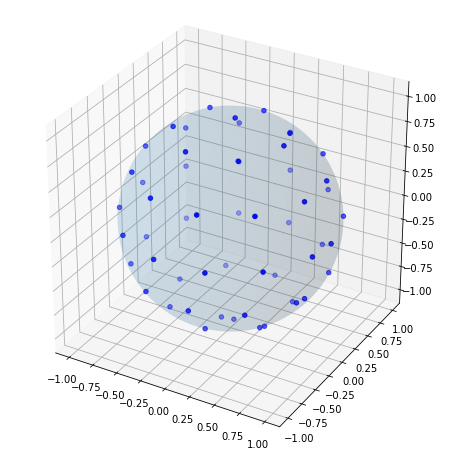

In [3]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
ax.plot_surface(np.outer(np.cos(u), np.sin(v)),
                np.outer(np.sin(u), np.sin(v)),
                np.outer(np.ones(np.size(u)), np.cos(v)),
                alpha=.1)

ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', marker='o')

plt.gca().set_aspect('equal')
plt.show()

## Computing $R$ (coverage radius)

To compute $R$, we considered:

### Spherical voronoi diagram

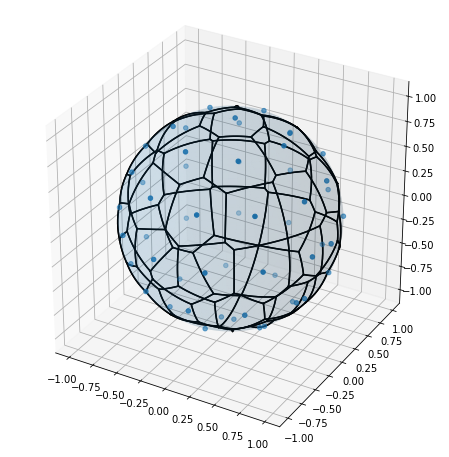

In [4]:
sv = SphericalVoronoi(points)
sv.sort_vertices_of_regions()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
ax.plot_surface(np.outer(np.cos(u), np.sin(v)),
                np.outer(np.sin(u), np.sin(v)),
                np.outer(np.ones(np.size(u)), np.cos(v)),
                alpha=.1)

ax.scatter(points[:, 0],
           points[:, 1],
           points[:, 2])


t = np.linspace(0, 1, 10)
for region in sv.regions:
    n = len(region)
    for i in range(n):
        start = sv.vertices[region][i]
        end = sv.vertices[region][(i + 1) % n]
        result = geometric_slerp(start, end, t)
        ax.plot(result[..., 0],
                result[..., 1],
                result[..., 2],
                c='k')

plt.gca().set_aspect('equal')
plt.show()

In [5]:
def spherical_voronoi_coverage_radius(points):
    sv = SphericalVoronoi(points)
    sv.sort_vertices_of_regions()
    R = max(distance_matrix(np.array([point]),
                            sv.vertices[sv.regions[i]]).max()
            for i, point in enumerate(sv.points))
    return R

print('Coverage radius:', spherical_voronoi_coverage_radius(points))

Coverage radius: 0.3621207618447775


### Čech complex

To compute the Čech complex, we used the MiniBall algorithm. To use it, we first found all subsets of points (up to a given size).

[array([[0. , 0. ],
       [0.5, 0.5],
       [0. , 1. ]])]
15


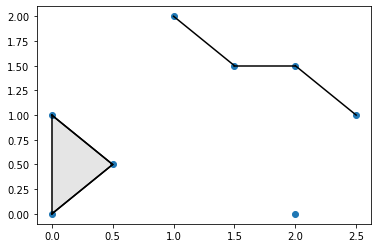

In [6]:
def powerset(points, max_size=3):
    """
    Compute the powerset of points.
    """
    return chain.from_iterable(combinations(points, r) for r in range(max_size, 0, -1))


def cech_complex(points, radius):
    """
    Compute the Cech complex.
    """
    cech_complex = []
    for subset in powerset(points):
        subset = np.array(subset)
        _, r = miniball.get_bounding_ball(subset)
        if r <= radius ** 2:
            cech_complex.append(subset)
        # if len(seen) == len(points):
        #     break

    return cech_complex


pts = np.array([[0, 0], [0.5, 0.5], [0, 1], [1, 2], [1.5, 1.5], [2, 1.5], [2.5, 1], [2, 0]])
ce = cech_complex(pts, 0.5)

print([simplex for simplex in ce if len(simplex) == 3])
print(len(ce))

plt.scatter(pts[:, 0], pts[:, 1])
for simplex in ce:
    plt.plot(simplex[:, 0], simplex[:, 1], c='k')
    if len(simplex) == 3:
        plt.fill(simplex[:, 0], simplex[:, 1], c='k', alpha=0.1)
plt.show()

As this is very slow, we can precompute all relevant radii, and compute the complex using the stored values.

In [7]:
def miniball_radii(points, max_size=3):
    """
    Compute the miniball radii for all subsets of points 
    (up to max_size).
    """
    radii = {}
    for subset in powerset(points, max_size=max_size):
        subset = np.array(subset)
        _, r = miniball.get_bounding_ball(subset)
        radii[hash((str(subset)))] = r
    return radii

radii = miniball_radii(points, max_size=3)

Now, we can "quickly" compute Čech, check if it is connected and compute the Euler characteristic. The coverage radius is then found by performing two bisections.

In [8]:
def fast_cech_complex(points, radii, radius, max_size=3):
    """
    Compute the Cech complex.
    """
    cech_complex = []
    for subset in powerset(points, max_size=max_size):
        subset = np.array(subset)
        if radii[hash((str(subset)))] <= radius ** 2:
            cech_complex.append(subset)

    return cech_complex


def cech_connected(points, radii, radius):
    """
    Check if the Cech complex is connected.
    Does so by counting unique vertices in 1-simplices (probably not the best way).
    """
    cech_complex = fast_cech_complex(points, radii, radius)
    dim1simplices = [simplex for simplex in cech_complex if len(simplex) == 2]
    seen = set()
    for simplex in dim1simplices:
        seen.add(hash(str(simplex[0])))
        seen.add(hash(str(simplex[1])))

    return len(seen) == len(points)


def cech_euler_characteristic(points, radii, radius):
    """
    Compute the Euler characteristic of the Cech complex.
    """
    cech_complex = fast_cech_complex(points, radii, radius)
    dim0 = len([simplex for simplex in cech_complex if len(simplex) == 1])
    dim1 = len([simplex for simplex in cech_complex if len(simplex) == 2])
    dim2 = len([simplex for simplex in cech_complex if len(simplex) == 3])
    return dim0 - dim1 + dim2


def cech_coverage_radius(points, radii, tolerance=1e-5):
    """
    Find the radius via bisecting the interval [0, 1].
    """
    left = 0
    right = 1
    while right - left > tolerance:
        mid = (left + right) / 2
        if cech_connected(points, radii, mid):
            right = mid
        else:
            left = mid
    
    left = mid 
    right = 1
    while right - left > tolerance:
        mid = (left + right) / 2
        if cech_euler_characteristic(points, radii, mid) >= 2:
            right = mid
        else:
            left = mid

    return right

R = cech_coverage_radius(points, radii)
print('Coverage radius: ', R)
print('Simplex connected: ', cech_connected(points, radii, R))
print('Euler characteristic: ', cech_euler_characteristic(points, radii, R))

Coverage radius:  0.3351080745924264
Simplex connected:  True
Euler characteristic:  2


In [9]:
# Just so we get a feeling for how the euler characteristic behaves.

for rad in np.linspace(0, 1, 20):
    print(rad, cech_euler_characteristic(points, radii, rad))

0.0 54
0.05263157894736842 52
0.10526315789473684 51
0.15789473684210525 49
0.21052631578947367 48
0.2631578947368421 -34
0.3157894736842105 -21
0.3684210526315789 39
0.42105263157894735 80
0.47368421052631576 162
0.5263157894736842 609
0.5789473684210527 1099
0.631578947368421 1502
0.6842105263157894 2349
0.7368421052631579 3865
0.7894736842105263 5200
0.8421052631578947 7227
0.894736842105263 10681
0.9473684210526315 14167
1.0 23423


### Alpha complex

As the Alpha complex is topologically equivalent to the Čech complex (at least if we trust the Gudhi documentation), we can compute it much faster, as it is part of the Gudhi library.

In [10]:
def alpha_connected(points, radius):
    """
    check if Alpha is connected via a depth-first search.
    """
    alpha_complex = gudhi.AlphaComplex(points=points)
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=radius ** 2)

    dim1simplices = [simplex for simplex in simplex_tree.get_skeleton(1) if len(simplex[0]) == 2]
    edges = {tuple(sorted(simplex[0])) for simplex in dim1simplices}

    def dfs(edges, start, visited=None):
        if visited is None:
            visited = set()
        visited.add(start)
        for edge in edges:
            if start in edge:
                other = edge[0] if edge[0] != start else edge[1]
                if other not in visited:
                    dfs(edges, other, visited)
        return visited

    return len(dfs(edges, 0)) == len(points)


def alpha_euler_characteristic(points, radius):
    """
    Compute the Euler characteristic of the Alpha complex.
    """
    alpha_complex = gudhi.AlphaComplex(points=points)
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=radius ** 2)

    dim0 = len([simplex for simplex in simplex_tree.get_skeleton(0)])
    dim1 = len([simplex for simplex in simplex_tree.get_skeleton(1) if len(simplex[0]) == 2])
    dim2 = len([simplex for simplex in simplex_tree.get_skeleton(2) if len(simplex[0]) == 3])
    return dim0 - dim1 + dim2


def alpha_coverage_radius(points, tolerance=1e-16):
    """
    Find the radius via bisecting the interval [0, 1].
    """
    left = 0
    right = 1
    while right - left > tolerance:
        mid = (left + right) / 2
        if alpha_connected(points, radius=mid):
            right = mid
        else:
            left = mid
    
    left = mid 
    right = 1
    while right - left > tolerance:
        mid = (left + right) / 2
        if alpha_euler_characteristic(points, mid) >= 2:
            right = mid
        else:
            left = mid

    return right

R = alpha_coverage_radius(points)
print('Coverage radius: ', R)
print('Simplex connected: ', alpha_connected(points, R))
print('Euler characteristic: ', alpha_euler_characteristic(points, R))

Coverage radius:  0.35613484552110825
Simplex connected:  True
Euler characteristic:  2


## Computing $r$ (connectivity radius)

To compute $r$, we considered:

### Vietoris-Rips complex

Using bisection, we can find the radius at which the complex connects.

In [11]:
def rips_connected(points, radius):
    """
    check if Rips is connected via a depth-first search.
    """
    rips_complex = gudhi.RipsComplex(points=points, max_edge_length=radius)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)

    dim1simplices = [simplex for simplex in simplex_tree.get_skeleton(1) if len(simplex[0]) == 2]
    edges = {tuple(sorted(simplex[0])) for simplex in dim1simplices}

    def dfs(edges, start, visited=None):
        if visited is None:
            visited = set()
        visited.add(start)
        for edge in edges:
            if start in edge:
                other = edge[0] if edge[0] != start else edge[1]
                if other not in visited:
                    dfs(edges, other, visited)
        return visited

    return len(dfs(edges, 0)) == len(points)


def rips_connectivity_radius(points, tolerance=1e-16):
    """
    Find the radius via bisecting the interval [0, 1].
    """
    left = 0
    right = 1
    while right - left > tolerance:
        mid = (left + right) / 2
        if rips_connected(points, radius=mid):
            right = mid
        else:
            left = mid
    return right

r = rips_connectivity_radius(points)
print('Connectivity radius: ', r)
print('Simplex connected: ', rips_connected(points, r))

Connectivity radius:  0.4965033379263023
Simplex connected:  True


### Persistence diagrams

We can build a persistence diagram of the Vietoris-Rips complex, and read at which radius it connects from there.

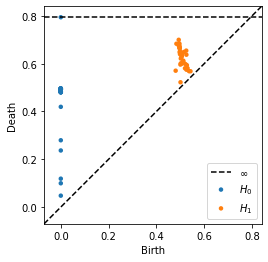

In [12]:
diagrams = ripser(points, maxdim=1)['dgms']
plot_diagrams(diagrams)

In [13]:
def persistence_diagram_connectivity_radius(points):
    diagram = ripser(points)['dgms'][0]
    r = diagram[diagram[:, 1] < float('inf')].max()
    return r

print('Connectivity radius: ', persistence_diagram_connectivity_radius(points))

Connectivity radius:  0.4965033233165741


## Computing the radii

In [14]:
def compute_radii(points, coverage='spherical_voronoi', connectivity='persistence_diagram'):
    if coverage == 'spherical_voronoi':
        sv = SphericalVoronoi(points)
        sv.sort_vertices_of_regions()
        R = max(distance_matrix(np.array([point]),
                                sv.vertices[sv.regions[i]]).max()
                for i, point in enumerate(sv.points))
    elif coverage == 'cech':
        R = cech_coverage_radius(points, radii)
    elif coverage == 'alpha':
        R = alpha_coverage_radius(points)
    else:
        raise ValueError('coverage must be one of "spherical_voronoi", "cech" or "alpha"')

    if connectivity == 'persistence_diagram':
        diagram = ripser(points)['dgms'][0]
        r = diagram[diagram[:, 1] < float('inf')].max()
    elif connectivity == 'rips':
        r = rips_connectivity_radius(points)
    else:
        raise ValueError('connectivity must be one of "persistence_diagram" or "rips"')

    return R, r

In [15]:
compute_radii(points, coverage='spherical_voronoi', connectivity='persistence_diagram')

(0.3621207618447775, 0.4965033233165741)

In [16]:
compute_radii(points, coverage='cech', connectivity='rips')

(0.3351080745924264, 0.4965033379263023)

In [17]:
compute_radii(points, coverage='alpha', connectivity='rips')

(0.35613484552110825, 0.4965033379263023)

## Finding obsolete points

To find unecessary points, we can compute the radii and then check if we get the same (or very similar) radii when one of the points is not included.

In [20]:
def find_obsolete(points, coverage='spherical_voronoi', connectivity='persistence_diagram'):
    R, r = compute_radii(points, coverage=coverage, connectivity=connectivity)
    obsolete = []
    for i in range(len(points)-1):
        points_without = np.delete(points, i, axis=0)
        R_without, r_without = compute_radii(points_without, coverage=coverage, connectivity=connectivity)
        # if R_without <= R and r_without <= r:
        if np.allclose([R_without, r_without], [R, r]):
            obsolete.append(i)
    n = len(obsolete)
    if n > 1:
        obsolete_combinations = []
        for comb in chain.from_iterable(combinations(obsolete, i + 1) for i in range(n)):
            points_without = np.delete(points, comb, axis=0)
            R_without, r_without = compute_radii(points_without, coverage=coverage, connectivity=connectivity)
            if np.allclose([R_without, r_without], [R, r]):
                obsolete_combinations.append(comb)
        obsolete += obsolete_combinations
    return obsolete

In [21]:
obs_arg = find_obsolete(points, coverage='alpha', connectivity='persistence_diagram')
obsolete = points[obs_arg]
for i in obs_arg:
    print(i, points[i])

2 [ 0.49942  -0.26344  -0.825336]


Once the obsolete points are found, we can plot them.


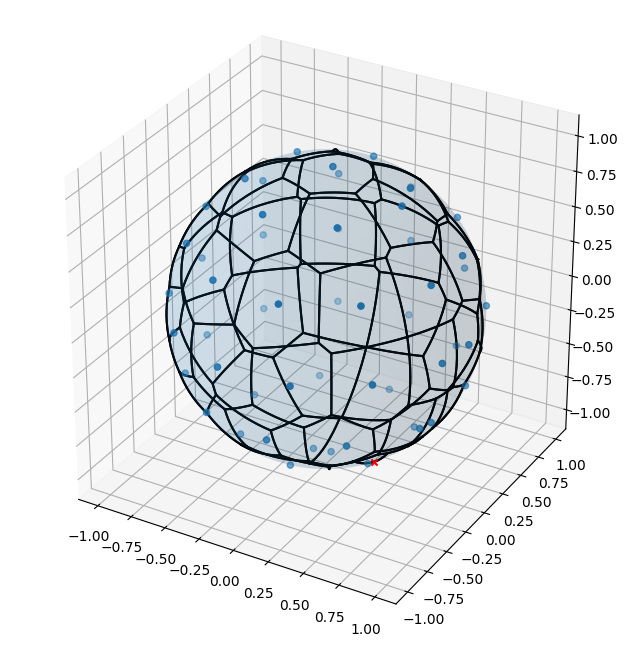

In [22]:
sv = SphericalVoronoi(points)
sv.sort_vertices_of_regions()
necessary = np.delete(points, obs_arg, axis=0)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
ax.plot_surface(np.outer(np.cos(u), np.sin(v)),
                np.outer(np.sin(u), np.sin(v)),
                np.outer(np.ones(np.size(u)), np.cos(v)),
                alpha=.1)

ax.scatter(necessary[:, 0],
           necessary[:, 1],
           necessary[:, 2])
ax.scatter(obsolete[:, 0],
           obsolete[:, 1],
           obsolete[:, 2],
           c='r', marker='x')

# ax.scatter(sv.vertices[:, 0], sv.vertices[:, 1], sv.vertices[:, 2])

t = np.linspace(0, 1, 10)
for region in sv.regions:
    n = len(region)
    for i in range(n):
        start = sv.vertices[region][i]
        end = sv.vertices[region][(i + 1) % n]
        result = geometric_slerp(start, end, t)
        ax.plot(result[..., 0],
                result[..., 1],
                result[..., 2],
                c='k')

plt.gca().set_aspect('equal')
plt.show()

## Point generation

The first idea was to use a Fibonacci lattice to generate points on the sphere.

In [23]:
def generate_points(samples=50):
    z = np.linspace(-1, 1, samples)
    r = np.sqrt(1 - z**2)
    phi = np.pi * (np.sqrt(5.) - 1.) * np.arange(samples)
    x = np.cos(phi) * r
    y = np.sin(phi) * r
    return np.c_[x, y, z]

In [24]:
compute_radii(generate_points(50))

(0.3835176045327419, 0.4985489845275879)

### Point Optimisation

This point distribution can further be optimized by using the idea of minimizing potential.

In [25]:
def sample_spherical(n, dim=3):
    v = np.random.randn(n, dim)
    v /= np.linalg.norm(v, axis=1)[:, None]
    return v

In [26]:
def potential(points, dim=3):
    points = points.reshape(-1, dim)
    points /= np.linalg.norm(points, axis=1)[:, None]
    dm = np.triu(distance_matrix(points, points))
    return np.log(np.sum(1 / dm[dm > 0] ** 2))


def constrain(points, dim=3):
    return sum(np.linalg.norm(points.reshape(-1, dim), axis=1) - 1)

In [27]:
points = sample_spherical(50)  # generate_points(50)

In [28]:
res = minimize(potential,
               points.reshape(-1),
               bounds=[(-1, 1)] * points.size,
               constraints={'type': 'eq', 'fun': constrain},
               method='SLSQP',
               options={'disp': True, 'maxiter': 1000})
out = res.x.reshape(-1, 3) / np.linalg.norm(res.x.reshape(-1, 3), axis=1)[:, None]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.020727040459955
            Iterations: 153
            Function evaluations: 23108
            Gradient evaluations: 153


In [29]:
compute_radii(out)

(0.3243685292192012, 0.544695258140564)